# Single Sample Method Benchmarking

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 06.01.2023
- **Date of Last Modification:** 04.09.2023

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../../nichecompass-reproducibility/utils")

In [3]:
import gc
import os
import shutil
import warnings
from datetime import datetime

import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import numpy as np
import pandas as pd
import pickle
import plottable
import scanpy as sc
import scib_metrics

from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                create_new_color_dict,
                                extract_gp_dict_from_mebocost_es_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps)

from benchmarking_utils import *

### 1.2 Define Parameters

In [4]:
metric_cols_sample_integration = [
    "gcs", "mlami", "cas", "clisis", # spatial conservation
    "cari", "cnmi", "casw", "clisi", # biological conservation
    "nasw", # cluster separability
    "basw", "bgc", "blisi" # batch correction
]
metric_col_weights_sample_integration = [ # separate for each category (later multiplied with category_col_weights)
    (1/6), (1/6), (1/3), (1/3), # spatial conservation
    (1/4), (1/4), (1/4), (1/4), # biological conservation
    1.0, # cluster separability
    (1/3), (1/3), (1/3) # batch correction
]
metric_col_titles_sample_integration = [
    "Graph Connectivity Similarity",
    "Maximum Leiden Adjusted Mutual Info",
    "Cell Type Affinity Similarity",
    "Cell Type Local Inverse Simpson's Index Similarity",
    "Cell Type Adjusted Rand Index",
    "Cell Type Normalized Mutual Info",
    "Cell Type Average Silhouette Width",
    "Cell Type Local Inverse Simpson's Index",
    "Cluster Average Silhouette Width",
    "Batch Average Silhouette Width",
    "Batch Graph Connectivity",
    "Batch Local Inverse Simpson's Index"
]
metric_cols_single_sample = metric_cols_sample_integration[:-3]
metric_col_weights_single_sample = metric_col_weights_sample_integration[:-3]
metric_col_titles_single_sample = metric_col_titles_sample_integration[:-3]

category_cols_sample_integration = [
    "Spatial Conservation Score",
    "Biological Conservation Score",
    "Cluster Separability Score",
    "Batch Correction Score"]
category_col_weights_sample_integration = [
    1,
    1,
    1,
    1]
category_col_titles_sample_integration = [
    "Spatial Conservation Score (25%)",
    "Biological Conservation Score (25%)",
    "Cluster Separability Score (25%)",
    "Batch Correction Score (25%)"]
category_col_weights_single_sample = category_col_weights_sample_integration[:-1]
category_cols_single_sample = category_cols_sample_integration[:-1]
category_col_titles_single_sample = [
    "Spatial Conservation Score",
    "Biological Conservation Score",
    "Cluster Separability Score"]

### 1.3 Run Notebook Setup

In [5]:
sc.set_figure_params(figsize=(6, 6))

In [6]:
# Ignore future warnings and user warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)

In [7]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

In [8]:
# Set mlflow tracking server (run it on the defined port)
mlflow.set_tracking_uri("http://localhost:8889")

### 1.4 Configure Paths and Directories

In [9]:
data_folder_path = "../../datasets/srt_data/gold"
artifact_folder_path = f"../../artifacts"
benchmarking_folder_path = f"{artifact_folder_path}/single_sample_method_benchmarking"

## 2. Method Benchmarking

- Run all model notebooks in the ```notebooks/single_sample_method_benchmarking``` directory before continuing.

### 2.1 Retrieve NicheCompass Runs

#### 2.1.1 seqFISH Mouse Organogenesis

#### 2.1.2 nanoString CosMx SMI Human Non-Small-Cell Lung Cancer (NSCLC)

#### 2.1.4 Vizgen MERFISH Mouse Liver

#### 2.1.5 Slide-seqV2 Mouse Hippocampus

### 2.1 Create Benchmarking Metrics Plots & Run Time Plots

#### 2.1.1 Slide-seqV2 Mouse Hippocampus

In [ ]:
datasets = ["slideseqv2_mouse_hippocampus"]
models = [#"nichecompass_gcnconv",
          "nichecompass_gatv2conv",
          "graphst",
          "deeplinc",
          "sagenet",
          "scvi",
          "expimap"]

summary_df = pd.DataFrame()
for dataset in datasets:
    for model in models:
        try:
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            benchmark_df[category_cols_single_sample[0]] = np.average(benchmark_df[metric_cols_single_sample[:4]], weights=metric_col_weights_single_sample[:4], axis=1)
            benchmark_df[category_cols_single_sample[1]] = np.average(benchmark_df[metric_cols_single_sample[4:8]], weights=metric_col_weights_single_sample[4:8], axis=1)
            benchmark_df[category_cols_single_sample[2]] = np.average(benchmark_df[metric_cols_single_sample[8:9]], weights=metric_col_weights_single_sample[8:9], axis=1)
            benchmark_df["Overall Score"] = np.average(benchmark_df[category_cols_single_sample[:3]], weights=category_col_weights_single_sample[:3] ,axis=1)
            summary_df = pd.concat([summary_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
                "run_time": [np.nan] * 8
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            summary_df = summary_df.append(missing_run_df, ignore_index=True)
            continue
 
# Reformat for plot
summary_df.replace({"nichecompass_gatv2conv": "NicheCompass",
                    "nichecompass_gcnconv": "NicheCompass Light",
                    "deeplinc": "DeepLinc",
                    "expimap": "expiMap",
                    "graphst": "GraphST",
                    "sagenet": "SageNet",
                    "scvi": "scVI"}, inplace=True)

# Filter for just second run
summary_df = summary_df[summary_df["run_number"] == 2]

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    category_cols_single_sample].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=category_cols_single_sample, # metric_cols_single_sample,
   var_name="score_type", 
   value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass", "DeepLinc", "GraphST", "SageNet"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

unrolled_df["model"] = unrolled_df["model"].replace("NicheCompass GATv2", "NicheCompass")
#unrolled_df["model"] = unrolled_df["model"].replace("NicheCompass GCN", "Mini NicheCompass")

In [ ]:
# Plot table
plot_simple_metrics_table(
    df=unrolled_df,
    model_col="model",
    model_col_width=1.4,
    group_col="dataset",
    metric_cols=category_cols_single_sample, # metric_cols_single_sample,
    metric_col_weights=category_col_weights_single_sample, # metric_col_weights_single_sample,
    metric_col_titles=[col.replace(" ", "\n") for col in category_col_titles_single_sample],
    metric_col_width=1.1, # 0.8,
    plot_width=8, # 32,
    plot_height=8,
    show=True,
    save_dir=benchmarking_folder_path,
    save_name=f"benchmarking_metrics_slideseqv2_mouse_hippocampus_run2.svg")

In [ ]:
dataset = "slideseqv2_mouse_hippocampus"
models = [#"nichecompass_gatv2conv",
          #"graphst",
          #"sagenet",
          #"deeplinc",
          #"scvi",
          #"expimap"
         ]

run_number = 2
leiden_resolutions = [#0.35,
                      #0.93,
                      #0.0775,
                      #1.1,
                      #0.875,
                      #1.55
                     ]

for i, model in enumerate(models):
    adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
    model = model.replace("_gcnconv", "").replace("_gatv2conv", "")
    adata.obs["sample"] = "sample1"
    
    print("\nComputing neighbor graph...")
    # Use latent representation for UMAP generation
    sc.pp.neighbors(adata,
                    use_rep=f"{model}_latent_run{run_number}",
                    key_added=f"{model}_latent_run{run_number}")

    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"{model}_latent_run{run_number}")
        
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolutions[i],
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    latent_cluster_colors = create_new_color_dict(
        adata=adata,
        cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}")
    
    plot_category_in_latent_and_physical_space(
            adata=adata,
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}",
            groups=None,
            sample_key="sample",
            samples=["sample1"],
            cat_colors=latent_cluster_colors,
            size=(720000 / len(adata)),
            spot_size=30,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}.svg")

In [ ]:
dataset = "slideseqv2_mouse_hippocampus"
models = ["nichecompass_gatv2conv"]
run_number = 2
leiden_resolutions = [0.35]

for i, model in enumerate(models):
    adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
    model = model.replace("_gcnconv", "").replace("_gatv2conv", "")
    adata.obs["sample"] = "sample1"
    
    print("\nComputing neighbor graph...")
    # Use latent representation for UMAP generation
    sc.pp.neighbors(adata,
                    use_rep=f"{model}_latent_run{run_number}",
                    key_added=f"{model}_latent_run{run_number}")

    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"{model}_latent_run{run_number}")
        
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolutions[i],
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    niche_annotations = {
        "0": "Stratum",
        "1": "Thalamus LD",
        "2": "Cortical layer 6a",
        "3": "Cortical layer 6b",
        "4": "Thalamus LP",
        "5": "Corpus callosum",
        "6": "CA1",
        "7": "Cortical layer 5",
        "8": "CA2 & CA3",
        "9": "Dentate gyrus",
        "10": "Medial habenula (MH)",
        "11": "Lateral habenula (LH)",
        "12": "Cortical layer 2/3",
        "13": "Third Ventricle (V3)"}

    adata.obs["niche"] = adata.obs["run2_leiden_0.35"].map(niche_annotations)

    latent_cluster_colors = create_new_color_dict(
        adata=adata,
        cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}")
    
    niche_colors = {niche: latent_cluster_colors[cluster] for cluster, niche in niche_annotations.items()}
    
    plot_category_in_latent_and_physical_space(
            adata=adata,
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"niche",
            groups=None,
            sample_key="sample",
            samples=["sample1"],
            cat_colors=niche_colors,
            size=(720000 / len(adata)),
            spot_size=30,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}.svg")

In [ ]:
sc.tl.dendrogram(adata=adata,
                 use_rep="nichecompass_latent_run2",
                 linkage_method="ward",
                 groupby="niche")

fig, (ax) = plt.subplots(1, 1, figsize=(2, 5))
sc.pl.dendrogram(
    adata=adata,
    groupby="niche",
    orientation="left",
    show=False,
    ax=ax)
plt.show()

In [ ]:
dataset = "slideseqv2_mouse_hippocampus"
models = ["graphst"]
run_number = 2
leiden_resolutions = [0.93]

for i, model in enumerate(models):
    adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
    model = model.replace("_gcnconv", "").replace("_gatv2conv", "")
    adata.obs["sample"] = "sample1"
    
    print("\nComputing neighbor graph...")
    # Use latent representation for UMAP generation
    sc.pp.neighbors(adata,
                    use_rep=f"{model}_latent_run{run_number}",
                    key_added=f"{model}_latent_run{run_number}")

    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"{model}_latent_run{run_number}")
        
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolutions[i],
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    niche_annotations = {
        "0": "Stratum",
        "1": "Lateral dorsal thalamus nucleus (LD)",
        "2": "Cortical Layers 5 & 2/3",
        "3": "Corpus callosum",
        "4": "Cortical Layer 6a",
        "5": "Cortical layer 6b",
        "6": "Lateral posterior thalamus nucleus (LP)",
        "7": "CA1",
        "8": "CA2 & CA3",
        "9": "Dentate gyrus",
        "10": "Third Ventricle (V3)",
        "11": "Medial habenula (MH)",
        "12": "Lateral habenula (LH)",
        "13": "Artifact"}

    adata.obs["niche"] = adata.obs["run2_leiden_0.93"].map(niche_annotations)

    niche_colors = {
     'Stratum': '#8BE0A4',
     'Lateral dorsal thalamus nucleus (LD)': '#F6CF71',
     'Cortical Layers 5 & 2/3': '#9EB9F3',
     'Cortical layer 6b': '#B497E7',
     'Lateral posterior thalamus nucleus (LP)': '#87C55F',
     'Corpus callosum': '#DAB6C4',
     'CA1': '#FE88B1',
     'Cortical layer 5': '#9EB9F3',
     'CA2 & CA3': '#DCB0F2',
     'Dentate gyrus': '#D3B484',
     'Medial habenula (MH)': '#F89C74',
     'Lateral habenula (LH)': '#C9DB74',
     'Cortical layer 2/3': '#276A8C',
     'Third Ventricle (V3)': '#B3B3B3',
     'Cortical Layer 6a': "#66C5CC",
     'Artifact': "#FF4D4D"}
    
    plot_category_in_latent_and_physical_space(
            adata=adata,
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"niche",
            groups=None,
            sample_key="sample",
            samples=["sample1"],
            cat_colors=niche_colors,
            size=(720000 / len(adata)),
            spot_size=30,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}.svg")

In [ ]:
sc.tl.dendrogram(adata=adata,
                 use_rep="graphst_latent_run2",
                 linkage_method="ward",
                 groupby="niche")

fig, (ax) = plt.subplots(1, 1, figsize=(2, 5))
sc.pl.dendrogram(
    adata=adata,
    groupby="niche",
    orientation="left",
    show=False,
    ax=ax)
plt.show()

In [ ]:
dataset = "slideseqv2_mouse_hippocampus"
models = ["sagenet"]
run_number = 2
leiden_resolutions = [0.0775]

for i, model in enumerate(models):
    adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
    model = model.replace("_gcnconv", "").replace("_gatv2conv", "")
    adata.obs["sample"] = "sample1"
    
    print("\nComputing neighbor graph...")
    # Use latent representation for UMAP generation
    sc.pp.neighbors(adata,
                    use_rep=f"{model}_latent_run{run_number}",
                    key_added=f"{model}_latent_run{run_number}")

    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"{model}_latent_run{run_number}")
        
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolutions[i],
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    latent_cluster_colors = {
        "0": "#9EB9F3",
        "1": "#DAB6C4",
        "2": "#87C55F",
        "3": "#F6CF71",
        "4": "#9B4DCA",
        "5": "#276A8C",
        "6": "#8BE0A4",
        "7": "#DCB0F2",
        "8": "#FF9CDA",
        "9": "#F89C74",
        "10": "#FE88B1",
        "11": "#66C5CC",
        "12": "#D3B484",
        "13": "#B3B3B3"}
    
    plot_category_in_latent_and_physical_space(
            adata=adata,
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}",
            groups=None,
            sample_key="sample",
            samples=["sample1"],
            cat_colors=latent_cluster_colors,
            size=(720000 / len(adata)),
            spot_size=30,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}.svg")

In [ ]:
dataset = "slideseqv2_mouse_hippocampus"
models = ["deeplinc"]
run_number = 2
leiden_resolutions = [1.05]

for i, model in enumerate(models):
    adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
    model = model.replace("_gcnconv", "").replace("_gatv2conv", "")
    adata.obs["sample"] = "sample1"
    
    print("\nComputing neighbor graph...")
    # Use latent representation for UMAP generation
    sc.pp.neighbors(adata,
                    use_rep=f"{model}_latent_run{run_number}",
                    key_added=f"{model}_latent_run{run_number}")

    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"{model}_latent_run{run_number}")
        
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolutions[i],
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    latent_cluster_colors = {
        "0": "#66C5CC",
        "1": "#F6CF71",
        "2": "#87C55F",
        "3": "#D3B484",
        "4": "#DAB6C4",
        "5": "#FE88B1",
        "6": "#B497E7",
        "7": "#8BE0A4",
        "8": "#F89C74",
        "9": "#DCB0F2",
        "10": "#276A8C",
        "11": "#FF00FF",
        "12": "#B3B3B3",
        "13": "#DA70D6"}
    
    plot_category_in_latent_and_physical_space(
            adata=adata,
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}",
            groups=None,
            sample_key="sample",
            samples=["sample1"],
            cat_colors=latent_cluster_colors,
            size=(720000 / len(adata)),
            spot_size=30,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}.svg")

In [ ]:
dataset = "slideseqv2_mouse_hippocampus"
models = ["scvi"]
run_number = 2
leiden_resolutions = [0.875]

for i, model in enumerate(models):
    adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
    model = model.replace("_gcnconv", "").replace("_gatv2conv", "")
    adata.obs["sample"] = "sample1"
    
    print("\nComputing neighbor graph...")
    # Use latent representation for UMAP generation
    sc.pp.neighbors(adata,
                    use_rep=f"{model}_latent_run{run_number}",
                    key_added=f"{model}_latent_run{run_number}")

    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"{model}_latent_run{run_number}")
        
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolutions[i],
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    latent_cluster_colors = {
        "0": "#66C5CC",
        "1": "#8BE0A4",
        "2": "#DAB6C4",
        "3": "#F6CF71",
        "4": "#87C55F",
        "5": "#9D88A2",
        "6": "#F89C74",
        "7": "#BA55D3",
        "8": "#B3B3B3",
        "9": "#D3B484",
        "10": "#8A2BE2",
        "11": "#FE88B1",
        "12": "#DCB0F2",
        "13": "#276A8C"}
    
    plot_category_in_latent_and_physical_space(
            adata=adata,
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}",
            groups=None,
            sample_key="sample",
            samples=["sample1"],
            cat_colors=latent_cluster_colors,
            size=(720000 / len(adata)),
            spot_size=30,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}.svg")

In [ ]:
dataset = "slideseqv2_mouse_hippocampus"
models = ["expimap"]
run_number = 2
leiden_resolutions = [1.5]

for i, model in enumerate(models):
    adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
    model = model.replace("_gcnconv", "").replace("_gatv2conv", "")
    adata.obs["sample"] = "sample1"
    
    print("\nComputing neighbor graph...")
    # Use latent representation for UMAP generation
    sc.pp.neighbors(adata,
                    use_rep=f"{model}_latent_run{run_number}",
                    key_added=f"{model}_latent_run{run_number}")

    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"{model}_latent_run{run_number}")
        
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolutions[i],
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    latent_cluster_colors = {
        "0": "#66C5CC",
        "1": "#F6CF71",
        "2": "#DAB6C4",
        "3": "#8BE0A4",
        "4": "#9D88A2",
        "5": "#FE88B1",
        "6": "#F89C74",
        "7": "#D3B484",
        "8": "#8A2BE2",
        "9": "#FF00FF",
        "10": "#48D1CC",
        "11": "#B3B3B3",
        "12": "#B497E7",
        "13": "#9B4DCA"}
    
    plot_category_in_latent_and_physical_space(
            adata=adata,
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}",
            groups=None,
            sample_key="sample",
            samples=["sample1"],
            cat_colors=latent_cluster_colors,
            size=(720000 / len(adata)),
            spot_size=30,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}.svg")


Computing neighbor graph...


/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/h


Computing UMAP embedding...

Computing Leiden clustering...


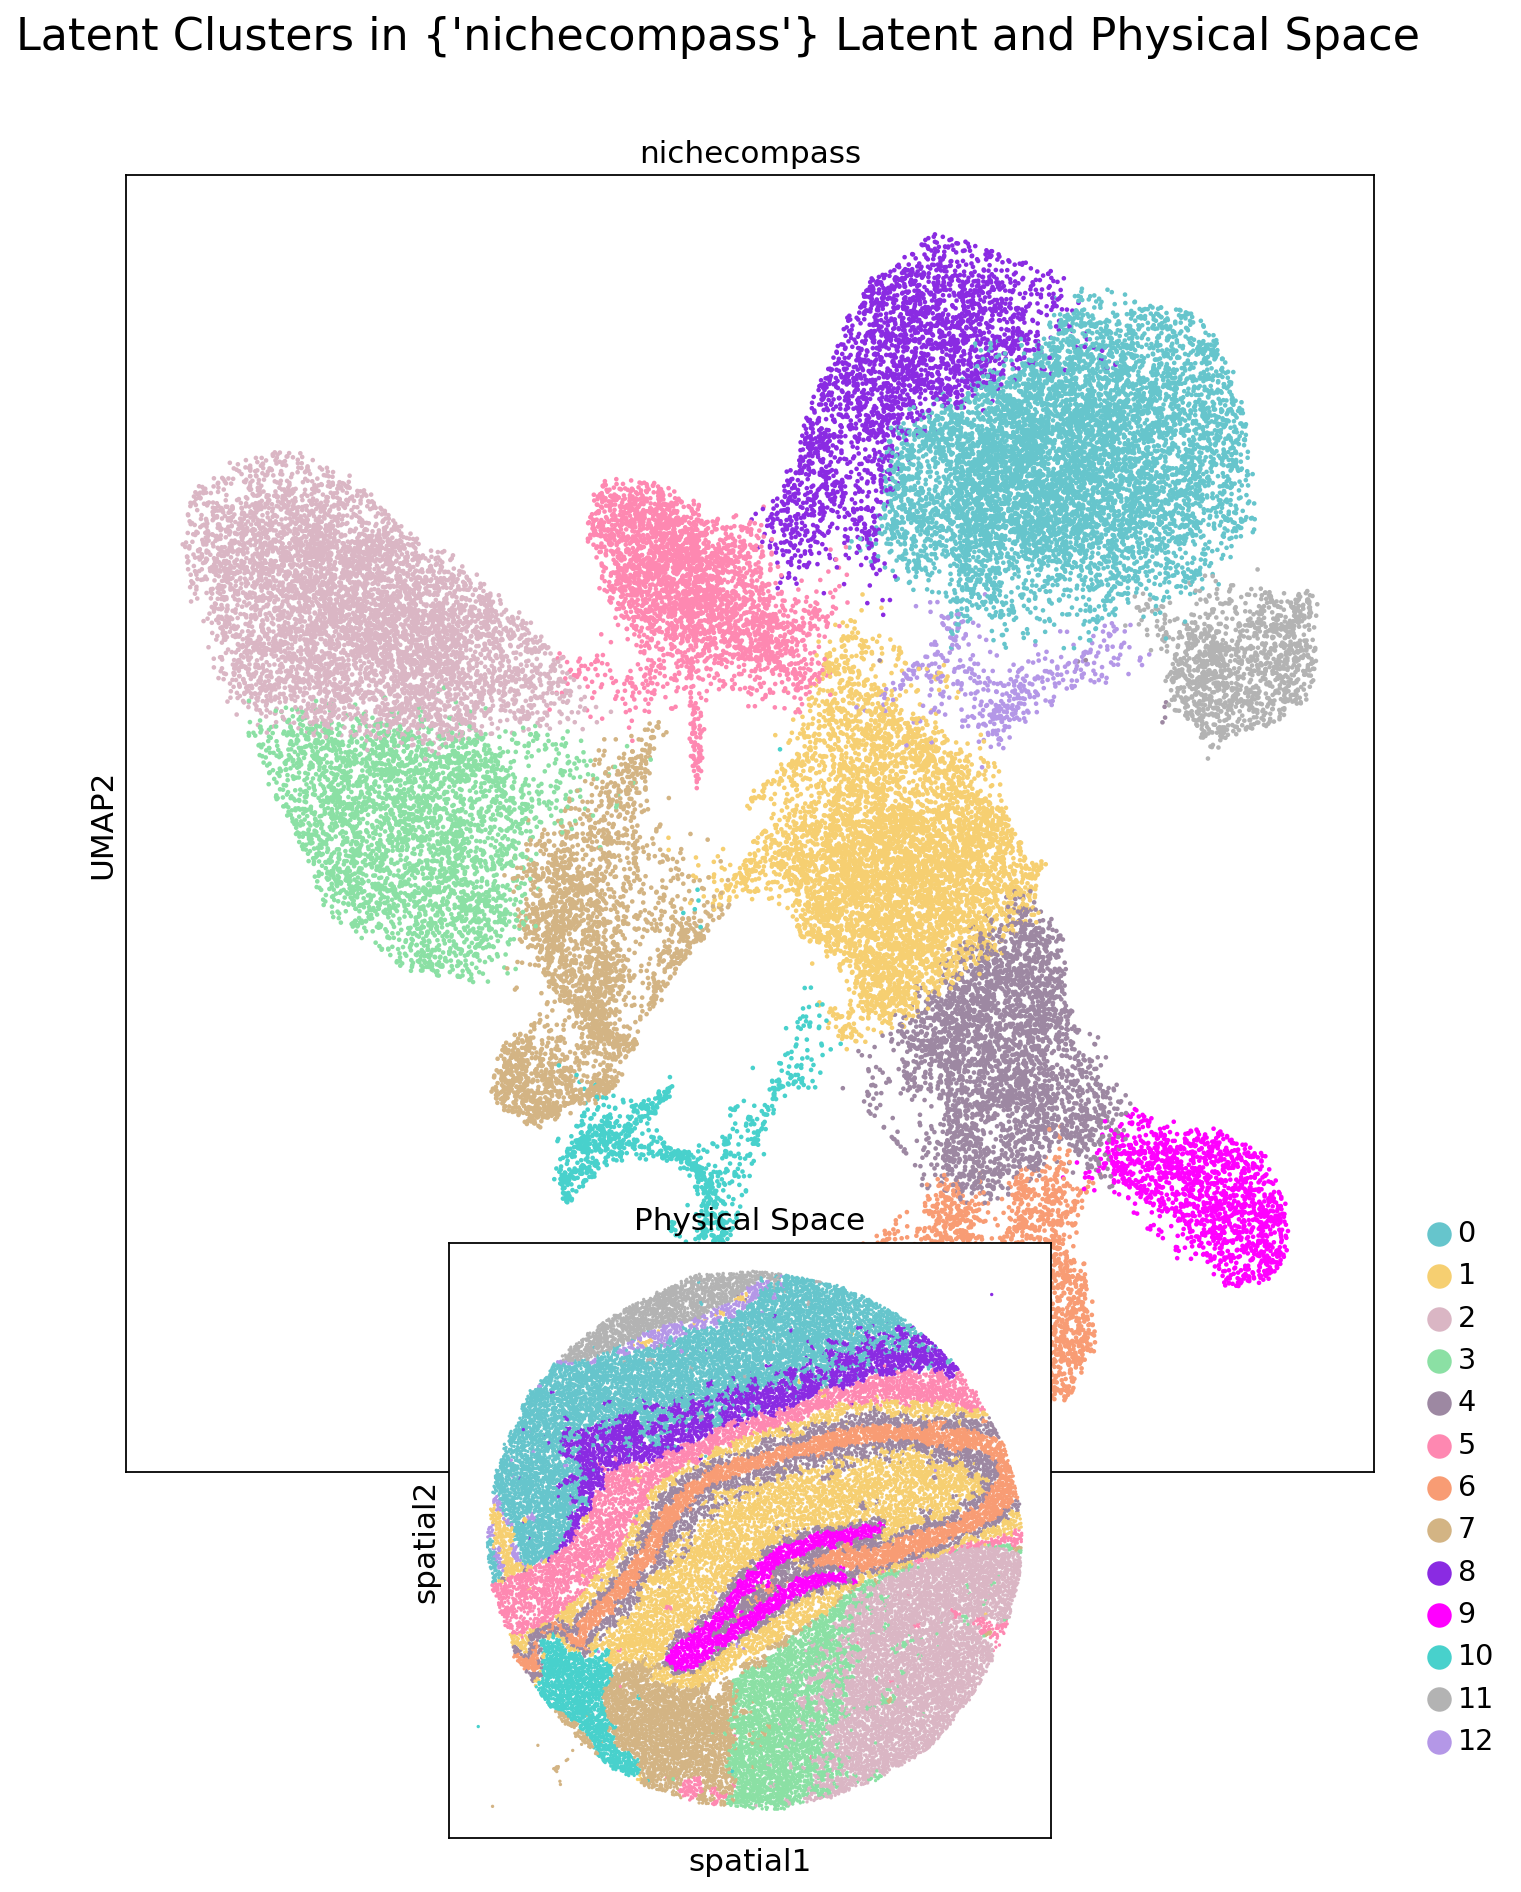

In [26]:
dataset = "slideseqv2_mouse_hippocampus"
models = ["nichecompass_gcnconv"]
run_number = 2
leiden_resolutions = [0.35]

for i, model in enumerate(models):
    adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
    model = model.replace("_gcnconv", "").replace("_gatv2conv", "")
    adata.obs["sample"] = "sample1"
    
    print("\nComputing neighbor graph...")
    # Use latent representation for UMAP generation
    sc.pp.neighbors(adata,
                    use_rep=f"{model}_latent_run{run_number}",
                    key_added=f"{model}_latent_run{run_number}")

    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"{model}_latent_run{run_number}")
        
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolutions[i],
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    latent_cluster_colors = {
        "0": "#66C5CC",
        "1": "#F6CF71",
        "2": "#DAB6C4",
        "3": "#8BE0A4",
        "4": "#9D88A2",
        "5": "#FE88B1",
        "6": "#F89C74",
        "7": "#D3B484",
        "8": "#8A2BE2",
        "9": "#FF00FF",
        "10": "#48D1CC",
        "11": "#B3B3B3",
        "12": "#B497E7",
        "13": "#9B4DCA"}

    plot_category_in_latent_and_physical_space(
            adata=adata,
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}",
            groups=None,
            sample_key="sample",
            samples=["sample1"],
            cat_colors=latent_cluster_colors,
            size=(720000 / len(adata)),
            spot_size=30,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}.svg")

In [13]:
datasets = ["slideseqv2_mouse_hippocampus",
            "slideseqv2_mouse_hippocampus_subsample_50pct",
            "slideseqv2_mouse_hippocampus_subsample_25pct",
            "slideseqv2_mouse_hippocampus_subsample_10pct",
            "slideseqv2_mouse_hippocampus_subsample_5pct",
            "slideseqv2_mouse_hippocampus_subsample_1pct"]
models = ["nichecompass_gcnconv",
          "nichecompass_gatv2conv",
          "deeplinc",
          "graphst",
          "sagenet",
          "scvi",
          "expimap"]

summary_df = pd.DataFrame()
for dataset in datasets:
    for model in models:
        try:
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            benchmark_df[category_cols_single_sample[0]] = np.average(benchmark_df[metric_cols_single_sample[:4]], weights=metric_col_weights_single_sample[:4], axis=1)
            benchmark_df[category_cols_single_sample[1]] = np.average(benchmark_df[metric_cols_single_sample[4:8]], weights=metric_col_weights_single_sample[4:8], axis=1)
            benchmark_df[category_cols_single_sample[2]] = np.average(benchmark_df[metric_cols_single_sample[8:9]], weights=metric_col_weights_single_sample[8:9], axis=1)
            benchmark_df["Overall Score"] = np.average(benchmark_df[category_cols_single_sample[:3]], weights=category_col_weights_single_sample[:3] ,axis=1)
            summary_df = pd.concat([summary_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
                "run_time": [np.nan] * 8
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            summary_df = summary_df.append(missing_run_df, ignore_index=True)
            continue
 
# Reformat for plot
summary_df.replace({"nichecompass_gatv2conv": "NicheCompass",
                    "nichecompass_gcnconv": "NicheCompass Light",
                    "deeplinc": "DeepLinc",
                    "expimap": "expiMap",
                    "graphst": "GraphST",
                    "sagenet": "SageNet",
                    "scvi": "scVI"}, inplace=True)

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    category_cols_single_sample].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=category_cols_single_sample, # metric_cols_single_sample,
   var_name="score_type", 
   value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass GCN", "NicheCompass GATv2", "DeepLinc", "GraphST", "SageNet"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

#print(summary_df["model"].value_counts())
#print(summary_df[summary_df.isna().any(axis=1)])

Did not find file ../../artifacts/single_sample_method_benchmarking/slideseqv2_mouse_hippocampus_subsample_50pct_sagenet_metrics.csv. Continuing...
Did not find file ../../artifacts/single_sample_method_benchmarking/slideseqv2_mouse_hippocampus_subsample_25pct_sagenet_metrics.csv. Continuing...
Did not find file ../../artifacts/single_sample_method_benchmarking/slideseqv2_mouse_hippocampus_subsample_10pct_sagenet_metrics.csv. Continuing...
Did not find file ../../artifacts/single_sample_method_benchmarking/slideseqv2_mouse_hippocampus_subsample_5pct_sagenet_metrics.csv. Continuing...
Did not find file ../../artifacts/single_sample_method_benchmarking/slideseqv2_mouse_hippocampus_subsample_1pct_graphst_metrics.csv. Continuing...
Did not find file ../../artifacts/single_sample_method_benchmarking/slideseqv2_mouse_hippocampus_subsample_1pct_sagenet_metrics.csv. Continuing...


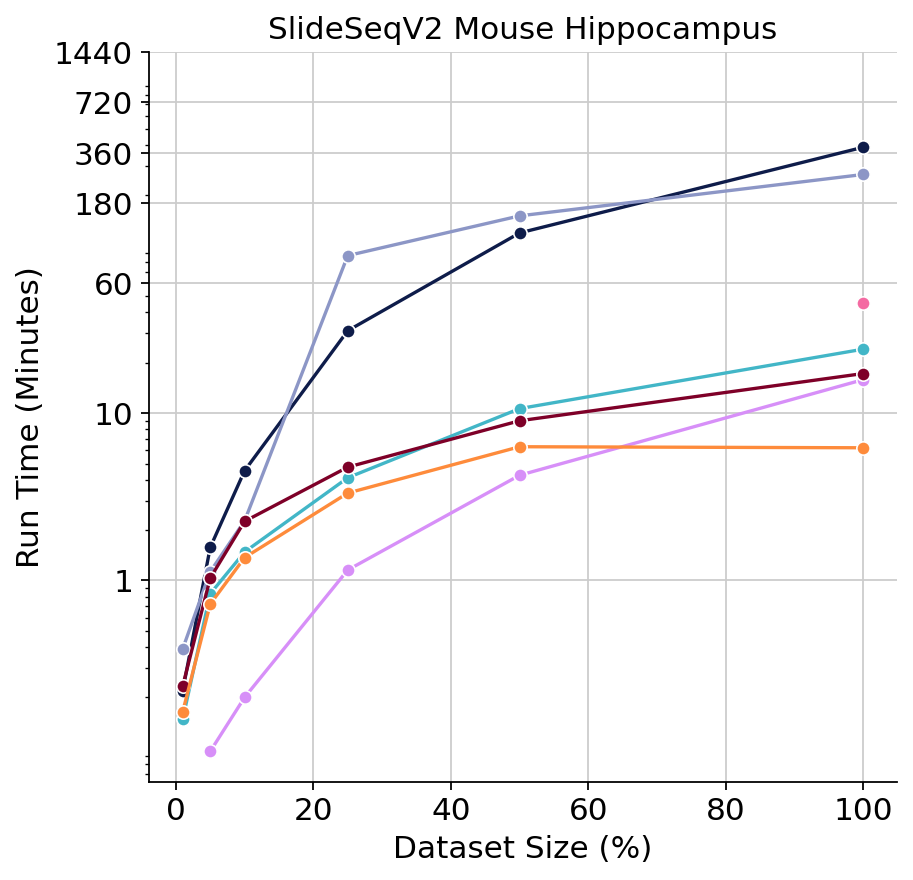

In [14]:
model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "SageNet": "#F46AA2",
                 "scVI": "#FE8B3B",
                 "expiMap": "#7E0028",
                 }

run_time_mean_df = summary_df.groupby(["dataset", "model"])[["run_time"]].mean().reset_index()
run_time_mean_df["run_time"] = run_time_mean_df["run_time"] / 60

def create_dataset_share_col(row):
    if row["dataset"] == "slideseqv2_mouse_hippocampus":
        return 100
    elif row["dataset"] == "slideseqv2_mouse_hippocampus_subsample_50pct":    
        return 50
    elif row["dataset"] == "slideseqv2_mouse_hippocampus_subsample_25pct":    
        return 25
    elif row["dataset"] == "slideseqv2_mouse_hippocampus_subsample_10pct":    
        return 10
    elif row["dataset"] == "slideseqv2_mouse_hippocampus_subsample_5pct":    
        return 5
    elif row["dataset"] == "slideseqv2_mouse_hippocampus_subsample_1pct":    
        return 1
    
run_time_mean_df["dataset_share"] = run_time_mean_df.apply(lambda row: create_dataset_share_col(row), axis=1)
    
ax = sns.lineplot(data=run_time_mean_df,
                  x="dataset_share",
                  y="run_time",
                  hue="model",
                  marker='o',
                  palette=model_palette)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title("SlideSeqV2 Mouse Hippocampus")
plt.ylabel("Run Time (Minutes)")
plt.xlabel("Dataset Size (%)")
custom_y_ticks = [1, 10, 60, 180, 360, 720, 1440]  # Adjust the tick positions as needed
plt.yscale("log")
plt.yticks(custom_y_ticks, custom_y_ticks)
legend = plt.gca().get_legend()
for handle in legend.legendHandles:
    handle.set_linewidth(4.0)  # Adjust the size as needed
handles, labels = legend.legendHandles, [text.get_text() for text in legend.get_texts()]
order = [3, 2, 4, 1, 0, 6, 5]
ordered_handles = [handles[i] for i in order]
ordered_labels = [labels[i] for i in order]
plt.legend(ordered_handles, ordered_labels)
ax = plt.gca()
ax.legend().set_visible(False)
plt.savefig(benchmarking_folder_path + "/benchmarking_runtimes_slideseqv2_mouse_hippocampus.svg")
plt.show()

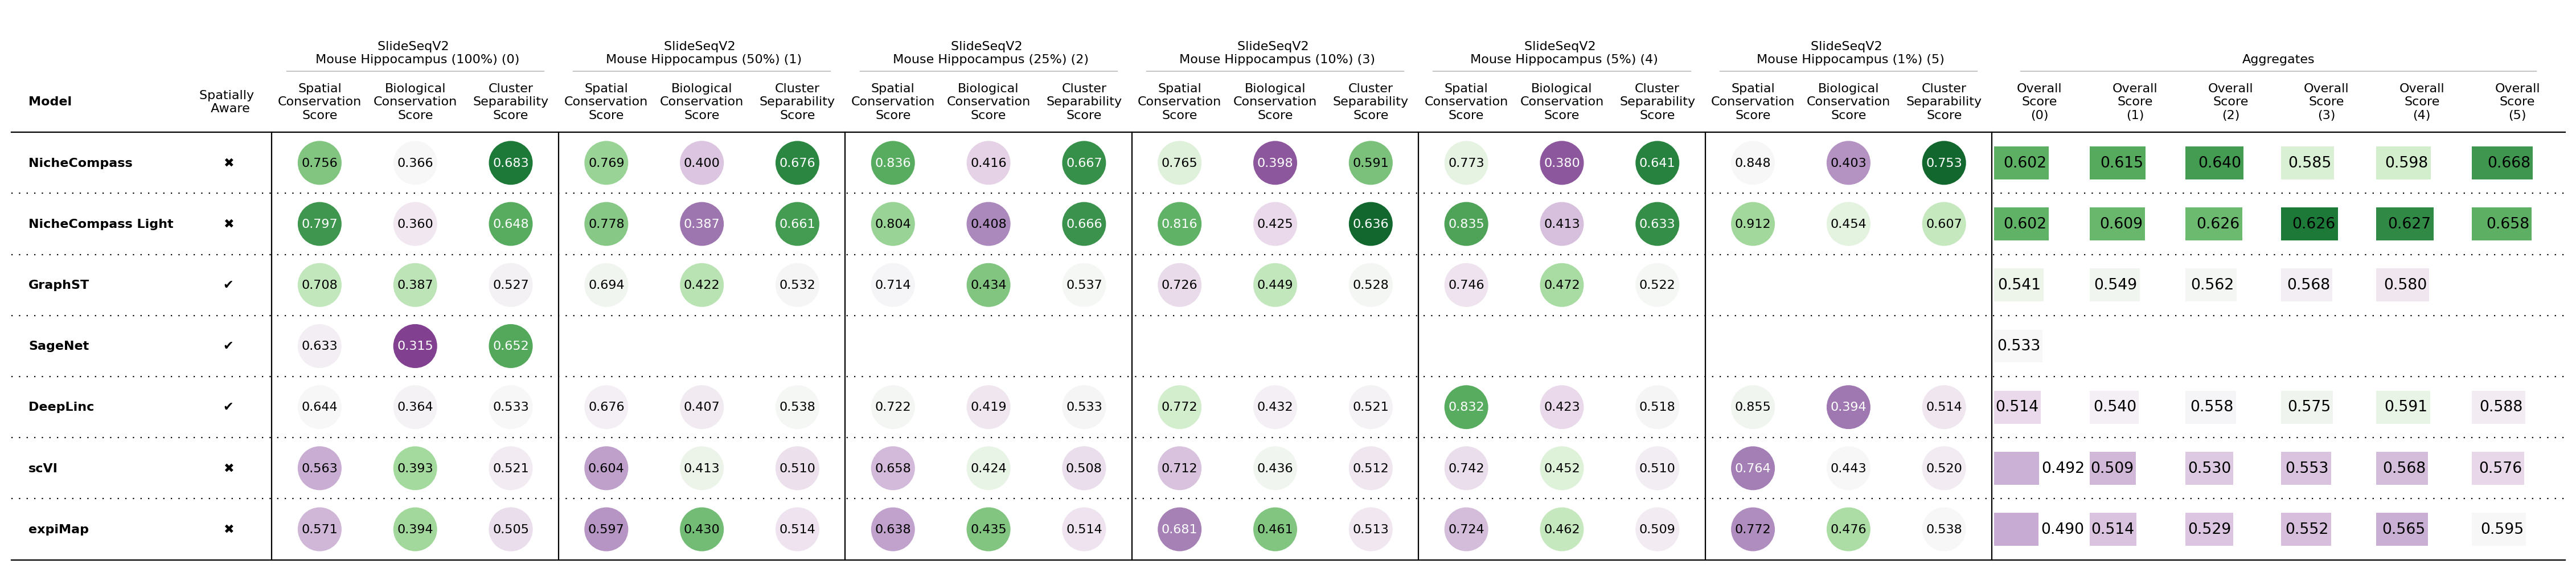

In [15]:
# Plot table
plot_metrics_table(
    df=unrolled_df,
    model_col="model",
    model_col_width=2.,
    group_col="dataset",
    metric_cols=category_cols_single_sample, # metric_cols_single_sample,
    metric_col_weights=category_col_weights_single_sample, # metric_col_weights_single_sample,
    metric_col_titles=[col.replace(" ", "\n") for col in category_col_titles_single_sample],
    metric_col_width=1.1, # 0.8,
    plot_width=36, # 32,
    plot_height=8,
    show=True,
    save_dir=benchmarking_folder_path,
    save_name=f"benchmarking_metrics_slideseqv2_mouse_hippocampus.svg")

#### 2.1.2 seqFISH Mouse Organogenesis

In [16]:
datasets = ["seqfish_mouse_organogenesis_embryo2",
            "seqfish_mouse_organogenesis_subsample_50pct_embryo2",
            "seqfish_mouse_organogenesis_subsample_25pct_embryo2",
            "seqfish_mouse_organogenesis_subsample_10pct_embryo2",
            "seqfish_mouse_organogenesis_subsample_5pct_embryo2",
            "seqfish_mouse_organogenesis_subsample_1pct_embryo2"]
models = ["nichecompass_gatv2conv",
          "nichecompass_gcnconv",
          "deeplinc",
          "graphst",
          "sagenet",
          "scvi",
          "expimap"]

summary_df = pd.DataFrame()
for dataset in datasets:
    for model in models:
        benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
        #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
        #training_durations = []
        #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
        #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
        #benchmark_df["run_time"] = training_durations
        #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
        #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
        benchmark_df["model"] = model
        benchmark_df[category_cols_single_sample[0]] = np.average(benchmark_df[metric_cols_single_sample[:4]], weights=metric_col_weights_single_sample[:4], axis=1)
        benchmark_df[category_cols_single_sample[1]] = np.average(benchmark_df[metric_cols_single_sample[4:8]], weights=metric_col_weights_single_sample[4:8], axis=1)
        benchmark_df[category_cols_single_sample[2]] = np.average(benchmark_df[metric_cols_single_sample[8:9]], weights=metric_col_weights_single_sample[8:9], axis=1)
        benchmark_df["Overall Score"] = np.average(benchmark_df[category_cols_single_sample[:3]], weights=category_col_weights_single_sample[:3] ,axis=1)
        summary_df = pd.concat([summary_df, benchmark_df], ignore_index=True)
 
# Reformat for plot
summary_df.replace({"nichecompass_gatv2conv": "NicheCompass",
                    "nichecompass_gcnconv": "NicheCompass Light",
                    "deeplinc": "DeepLinc",
                    "expimap": "expiMap",
                    "graphst": "GraphST",
                    "sagenet": "SageNet",
                    "scvi": "scVI"}, inplace=True)

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    category_cols_single_sample].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=category_cols_single_sample, # metric_cols_single_sample,
   var_name="score_type", 
   value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass GCN", "NicheCompass GATv2", "DeepLinc", "GraphST", "SageNet"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

print(summary_df["model"].value_counts())
print(summary_df[summary_df.isna().any(axis=1)])

NicheCompass          48
NicheCompass Light    48
DeepLinc              48
GraphST               48
SageNet               48
scVI                  48
expiMap               48
Name: model, dtype: int64
Empty DataFrame
Columns: [dataset, run_number, run_time, gcs, mlami, cas, clisis, nasw, cnmi, cari, casw, clisi, model, Spatial Conservation Score, Biological Conservation Score, Cluster Separability Score, Overall Score]
Index: []


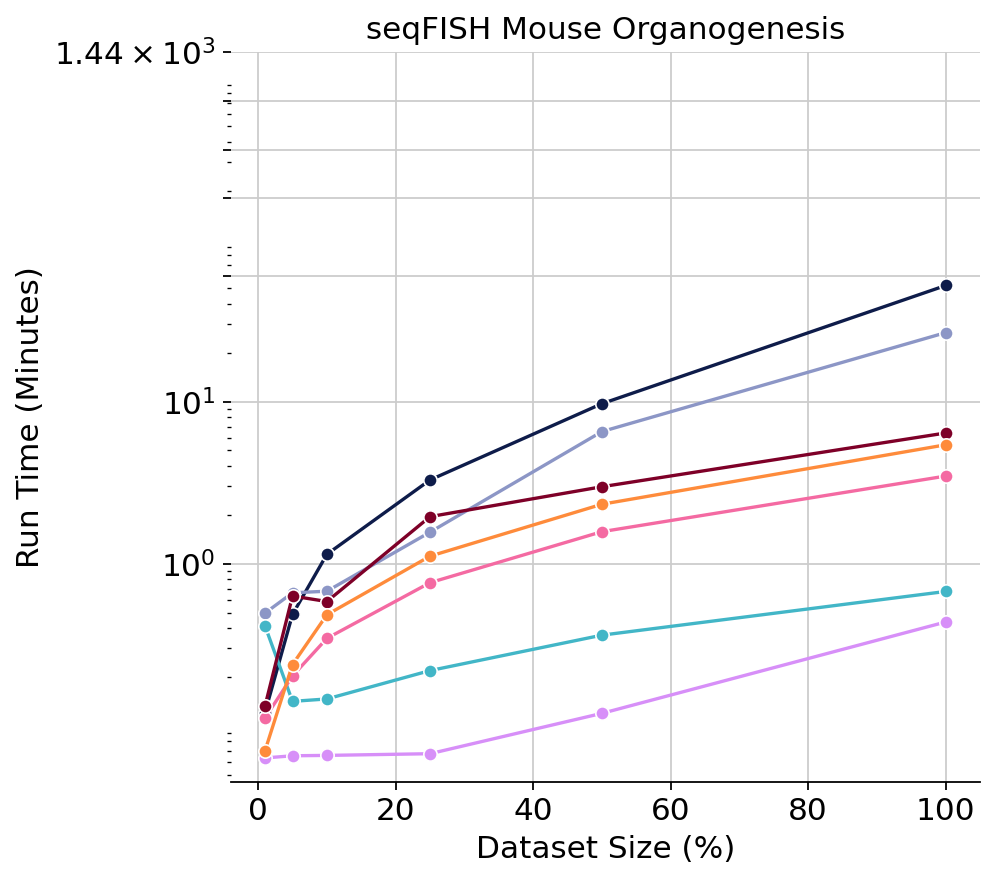

In [17]:
model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "SageNet": "#F46AA2",
                 "scVI": "#FE8B3B",
                 "expiMap": "#7E0028",
                 }

run_time_mean_df = summary_df.groupby(["dataset", "model"])[["run_time"]].mean().reset_index()
run_time_mean_df["run_time"] = run_time_mean_df["run_time"] / 60

def create_dataset_share_col(row):
    if row["dataset"] == "seqfish_mouse_organogenesis_embryo2":
        return 100
    elif row["dataset"] == "seqfish_mouse_organogenesis_subsample_50pct_embryo2":    
        return 50
    elif row["dataset"] == "seqfish_mouse_organogenesis_subsample_25pct_embryo2":    
        return 25
    elif row["dataset"] == "seqfish_mouse_organogenesis_subsample_10pct_embryo2":    
        return 10
    elif row["dataset"] == "seqfish_mouse_organogenesis_subsample_5pct_embryo2":    
        return 5
    elif row["dataset"] == "seqfish_mouse_organogenesis_subsample_1pct_embryo2":    
        return 1
    
run_time_mean_df["dataset_share"] = run_time_mean_df.apply(lambda row: create_dataset_share_col(row), axis=1)
    
ax = sns.lineplot(data=run_time_mean_df,
                  x="dataset_share",
                  y="run_time",
                  hue="model",
                  marker='o',
                  palette=model_palette)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title("seqFISH Mouse Organogenesis")
plt.ylabel("Run Time (Minutes)")
plt.xlabel("Dataset Size (%)")
custom_y_ticks = [1, 10, 60, 180, 360, 720, 1440]  # Adjust the tick positions as needed
plt.yscale("log")
plt.yticks(custom_y_ticks, None)
legend = plt.gca().get_legend()
for handle in legend.legendHandles:
    handle.set_linewidth(4.0)  # Adjust the size as needed
handles, labels = legend.legendHandles, [text.get_text() for text in legend.get_texts()]
order = [3, 2, 4, 1, 0, 6, 5]
ordered_handles = [handles[i] for i in order]
ordered_labels = [labels[i] for i in order]
plt.legend(ordered_handles, ordered_labels)
ax = plt.gca()
ax.legend().set_visible(False)
plt.savefig(benchmarking_folder_path + "/benchmarking_runtimes_seqfish_mouse_organogenesis.svg")
plt.show()

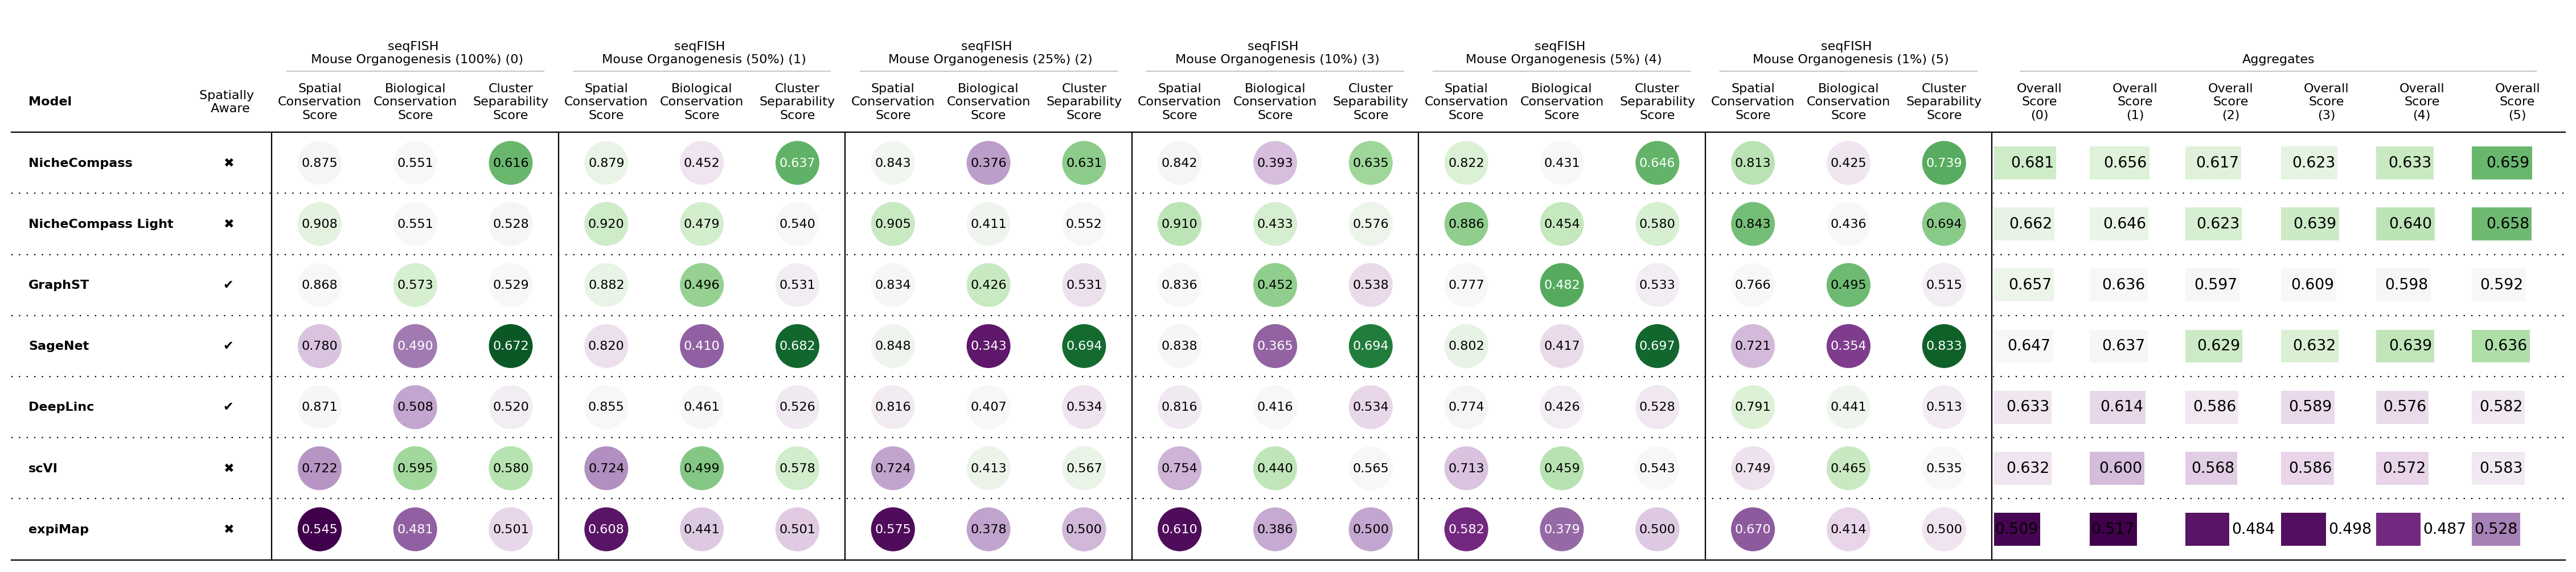

In [18]:
# Plot table
plot_metrics_table(
    df=unrolled_df,
    model_col="model",
    model_col_width=2.,
    group_col="dataset",
    metric_cols=category_cols_single_sample, # metric_cols_single_sample,
    metric_col_weights=category_col_weights_single_sample, # metric_col_weights_single_sample,
    metric_col_titles=[col.replace(" ", "\n") for col in category_col_titles_single_sample],
    metric_col_width=1.1, # 0.8,
    plot_width=36, # 32,
    plot_height=8,
    show=True,
    save_dir=benchmarking_folder_path,
    save_name=f"benchmarking_metrics_seqfish_mouse_organogenesis.svg")

#### 2.1.3 nanoString CosMx SMI Human Non-Small-Cell Lung Cancer (NSCLC)

In [19]:
datasets = ["nanostring_cosmx_human_nsclc_batch5",
            "nanostring_cosmx_human_nsclc_subsample_50pct_batch5",
            "nanostring_cosmx_human_nsclc_subsample_25pct_batch5",
            "nanostring_cosmx_human_nsclc_subsample_10pct_batch5",
            "nanostring_cosmx_human_nsclc_subsample_5pct_batch5",
            "nanostring_cosmx_human_nsclc_subsample_1pct_batch5"]
models = ["nichecompass_gcnconv",
          "nichecompass_gatv2conv",
          "deeplinc",
          "graphst",
          "sagenet",
          "scvi",
          "expimap"]

summary_df = pd.DataFrame()
for dataset in datasets:
    for model in models:
        try:
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            benchmark_df[category_cols_single_sample[0]] = np.average(benchmark_df[metric_cols_single_sample[:4]], weights=metric_col_weights_single_sample[:4], axis=1)
            benchmark_df[category_cols_single_sample[1]] = np.average(benchmark_df[metric_cols_single_sample[4:8]], weights=metric_col_weights_single_sample[4:8], axis=1)
            benchmark_df[category_cols_single_sample[2]] = np.average(benchmark_df[metric_cols_single_sample[8:9]], weights=metric_col_weights_single_sample[8:9], axis=1)
            benchmark_df["Overall Score"] = np.average(benchmark_df[category_cols_single_sample[:3]], weights=category_col_weights_single_sample[:3] ,axis=1)
            summary_df = pd.concat([summary_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            summary_df = summary_df.append(missing_run_df, ignore_index=True)
            continue
 
# Reformat for plot
summary_df.replace({"nichecompass_gatv2conv": "NicheCompass",
                    "nichecompass_gcnconv": "NicheCompass Light",
                    "deeplinc": "DeepLinc",
                    "expimap": "expiMap",
                    "graphst": "GraphST",
                    "sagenet": "SageNet",
                    "scvi": "scVI"}, inplace=True)

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    category_cols_single_sample].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=category_cols_single_sample, # metric_cols_single_sample,
   var_name="score_type", 
   value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass GCN", "NicheCompass GATv2", "DeepLinc", "GraphST", "SageNet"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

#print(summary_df["model"].value_counts())
#print(summary_df[summary_df.isna().any(axis=1)])

Did not find file ../../artifacts/single_sample_method_benchmarking/nanostring_cosmx_human_nsclc_batch5_deeplinc_metrics.csv. Continuing...
Did not find file ../../artifacts/single_sample_method_benchmarking/nanostring_cosmx_human_nsclc_batch5_graphst_metrics.csv. Continuing...
Did not find file ../../artifacts/single_sample_method_benchmarking/nanostring_cosmx_human_nsclc_batch5_sagenet_metrics.csv. Continuing...


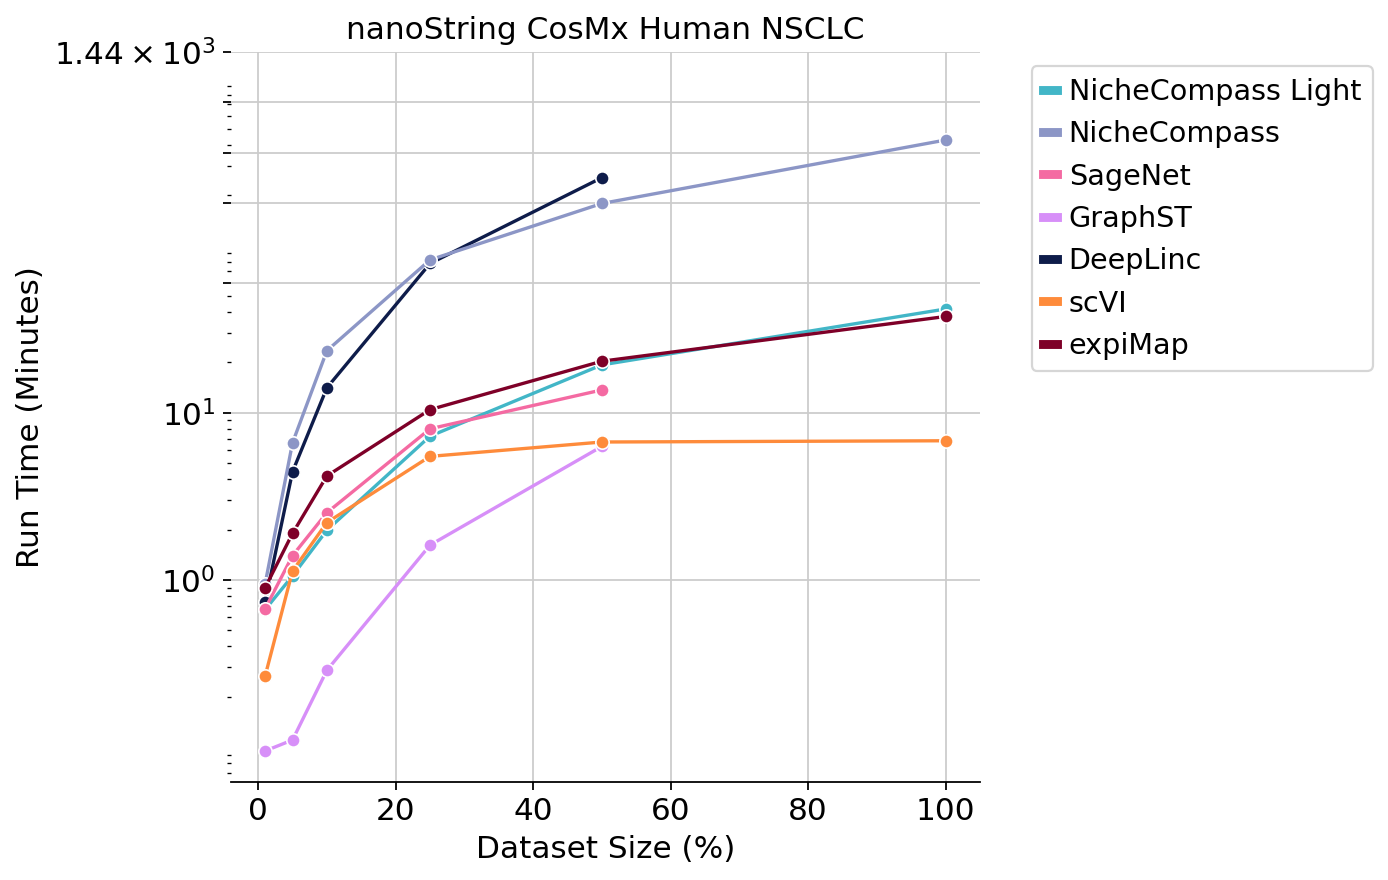

In [20]:
model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "SageNet": "#F46AA2",
                 "scVI": "#FE8B3B",
                 "expiMap": "#7E0028",
                 }

run_time_mean_df = summary_df.groupby(["dataset", "model"])[["run_time"]].mean().reset_index()
run_time_mean_df["run_time"] = run_time_mean_df["run_time"] / 60

def create_dataset_share_col(row):
    if row["dataset"] == "nanostring_cosmx_human_nsclc_batch5":
        return 100
    elif row["dataset"] == "nanostring_cosmx_human_nsclc_subsample_50pct_batch5":    
        return 50
    elif row["dataset"] == "nanostring_cosmx_human_nsclc_subsample_25pct_batch5":    
        return 25
    elif row["dataset"] == "nanostring_cosmx_human_nsclc_subsample_10pct_batch5":    
        return 10
    elif row["dataset"] == "nanostring_cosmx_human_nsclc_subsample_5pct_batch5":    
        return 5
    elif row["dataset"] == "nanostring_cosmx_human_nsclc_subsample_1pct_batch5":    
        return 1
    
run_time_mean_df["dataset_share"] = run_time_mean_df.apply(lambda row: create_dataset_share_col(row), axis=1)
    
ax = sns.lineplot(data=run_time_mean_df,
                  x="dataset_share",
                  y="run_time",
                  hue="model",
                  marker='o',
                  palette=model_palette)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title("nanoString CosMx Human NSCLC")
plt.ylabel("Run Time (Minutes)")
plt.xlabel("Dataset Size (%)")
custom_y_ticks = [1, 10, 60, 180, 360, 720, 1440]  # Adjust the tick positions as needed
plt.yscale("log")
plt.yticks(custom_y_ticks, None)
legend = plt.gca().get_legend()
for handle in legend.legendHandles:
    handle.set_linewidth(4.0)  # Adjust the size as needed
handles, labels = legend.legendHandles, [text.get_text() for text in legend.get_texts()]
order = [3, 2, 4, 1, 0, 6, 5]
ordered_handles = [handles[i] for i in order]
ordered_labels = [labels[i] for i in order]
lgd = plt.legend(ordered_handles, ordered_labels, bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.gca()
#ax.legend().set_visible(False)
plt.savefig(benchmarking_folder_path + "/benchmarking_runtimes_nanostring_cosmx_human_nsclc.svg", bbox_inches="tight", bbox_extra_artists=[lgd])
plt.show()

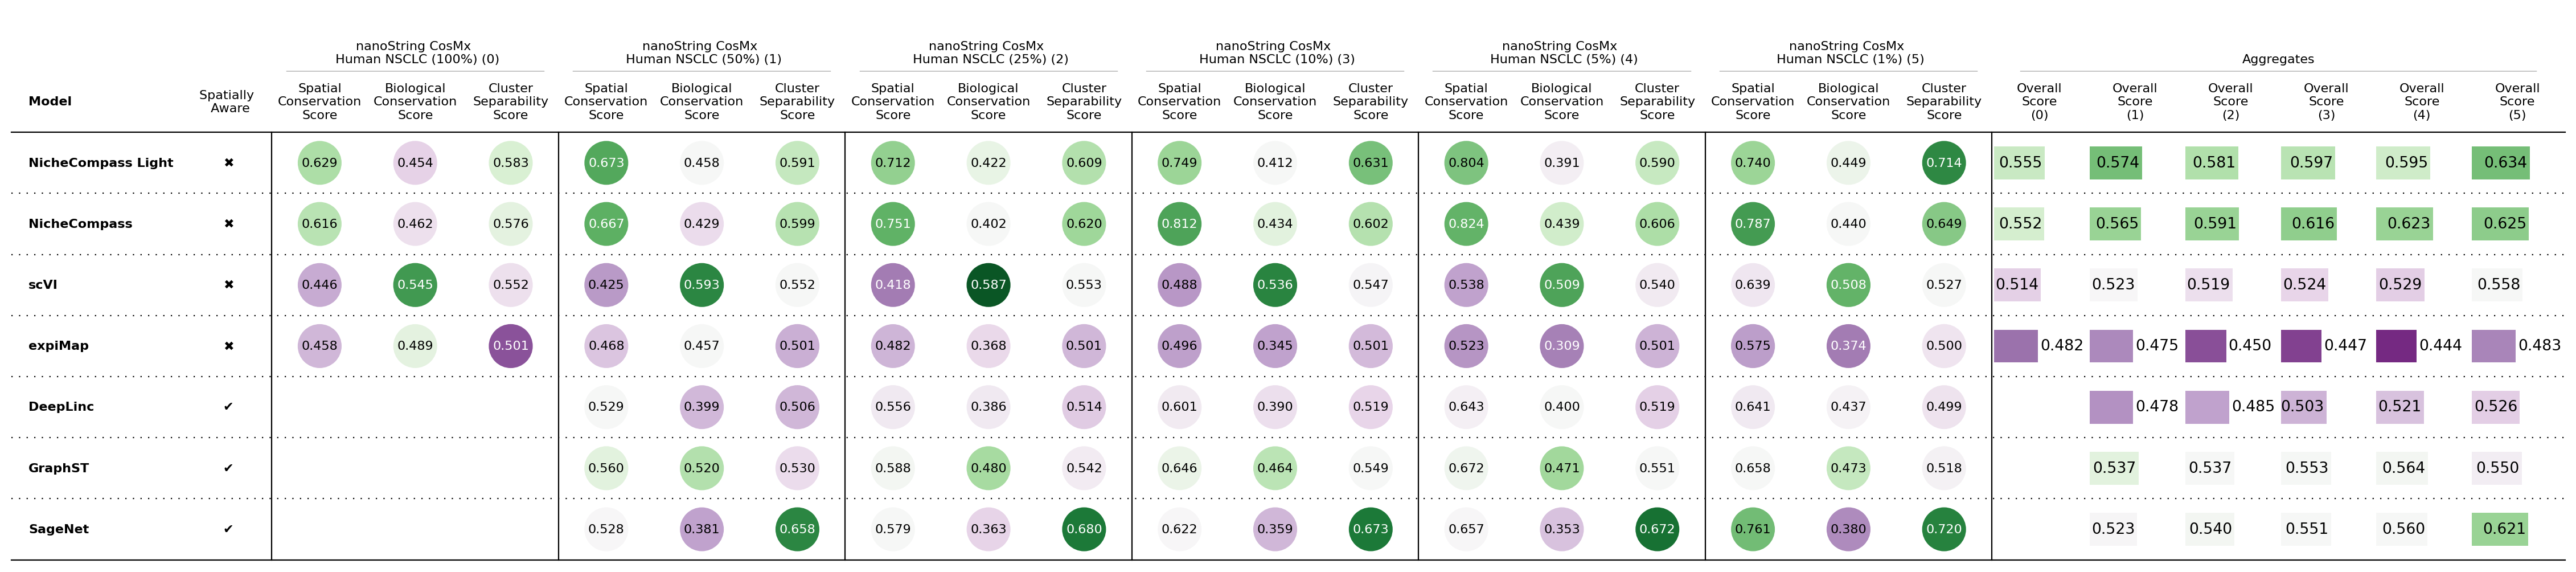

In [21]:
# Plot table
plot_metrics_table(
    df=unrolled_df,
    model_col="model",
    model_col_width=2.,
    group_col="dataset",
    metric_cols=category_cols_single_sample, # metric_cols_single_sample,
    metric_col_weights=category_col_weights_single_sample, # metric_col_weights_single_sample,
    metric_col_titles=[col.replace(" ", "\n") for col in category_col_titles_single_sample],
    metric_col_width=1.1, # 0.8,
    plot_width=36, # 32,
    plot_height=8,
    show=True,
    save_dir=benchmarking_folder_path,
    save_name=f"benchmarking_metrics_nanostring_cosmx_human_nsclc.svg")

#### 2.1.4 Vizgen MERFISH Mouse Liver

In [22]:
datasets = ["vizgen_merfish_mouse_liver",
            "vizgen_merfish_mouse_liver_subsample_50pct",
            "vizgen_merfish_mouse_liver_subsample_25pct",
            "vizgen_merfish_mouse_liver_subsample_10pct",
            "vizgen_merfish_mouse_liver_subsample_5pct",
            "vizgen_merfish_mouse_liver_subsample_1pct"]
models = ["nichecompass_gcnconv",
          "nichecompass_gatv2conv",
          "deeplinc",
          "graphst",
          "sagenet",
          "scvi",
          "expimap"]

summary_df = pd.DataFrame()
for dataset in datasets:
    for model in models:
        try:
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            benchmark_df[category_cols_single_sample[0]] = np.average(benchmark_df[metric_cols_single_sample[:4]], weights=metric_col_weights_single_sample[:4], axis=1)
            benchmark_df[category_cols_single_sample[1]] = np.average(benchmark_df[metric_cols_single_sample[4:8]], weights=metric_col_weights_single_sample[4:8], axis=1)
            benchmark_df[category_cols_single_sample[2]] = np.average(benchmark_df[metric_cols_single_sample[8:9]], weights=metric_col_weights_single_sample[8:9], axis=1)
            benchmark_df["Overall Score"] = np.average(benchmark_df[category_cols_single_sample[:3]], weights=category_col_weights_single_sample[:3] ,axis=1)
            summary_df = pd.concat([summary_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
                "run_time": [np.nan] * 8
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            summary_df = summary_df.append(missing_run_df, ignore_index=True)
            continue
 
# Reformat for plot
summary_df.replace({"nichecompass_gatv2conv": "NicheCompass",
                    "nichecompass_gcnconv": "NicheCompass Light",
                    "deeplinc": "DeepLinc",
                    "expimap": "expiMap",
                    "graphst": "GraphST",
                    "sagenet": "SageNet",
                    "scvi": "scVI"}, inplace=True)

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    category_cols_single_sample].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=category_cols_single_sample, # metric_cols_single_sample,
   var_name="score_type", 
   value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass GCN", "NicheCompass GATv2", "DeepLinc", "GraphST", "SageNet"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

#print(summary_df["model"].value_counts())
#print(summary_df[summary_df.isna().any(axis=1)])

Did not find file ../../artifacts/single_sample_method_benchmarking/vizgen_merfish_mouse_liver_deeplinc_metrics.csv. Continuing...
Did not find file ../../artifacts/single_sample_method_benchmarking/vizgen_merfish_mouse_liver_graphst_metrics.csv. Continuing...
Did not find file ../../artifacts/single_sample_method_benchmarking/vizgen_merfish_mouse_liver_sagenet_metrics.csv. Continuing...
Did not find file ../../artifacts/single_sample_method_benchmarking/vizgen_merfish_mouse_liver_subsample_50pct_deeplinc_metrics.csv. Continuing...
Did not find file ../../artifacts/single_sample_method_benchmarking/vizgen_merfish_mouse_liver_subsample_50pct_graphst_metrics.csv. Continuing...
Did not find file ../../artifacts/single_sample_method_benchmarking/vizgen_merfish_mouse_liver_subsample_50pct_sagenet_metrics.csv. Continuing...
Did not find file ../../artifacts/single_sample_method_benchmarking/vizgen_merfish_mouse_liver_subsample_25pct_deeplinc_metrics.csv. Continuing...
Did not find file ../..

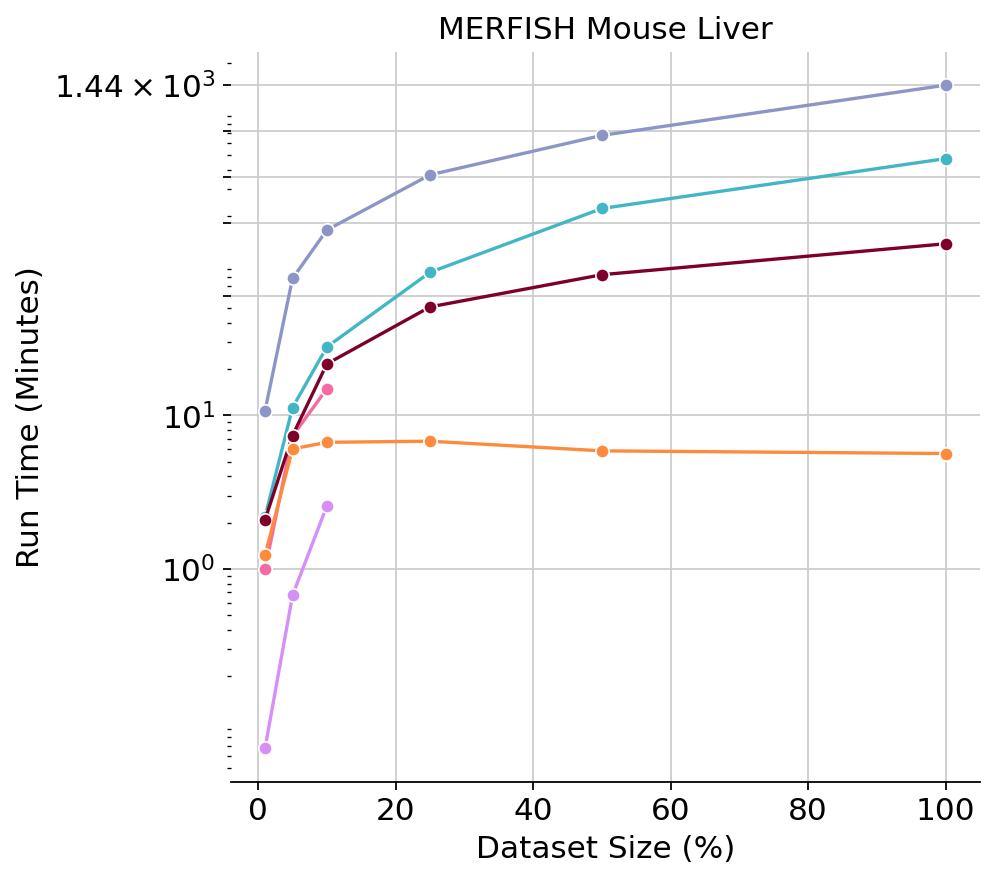

In [23]:
model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "SageNet": "#F46AA2",
                 "scVI": "#FE8B3B",
                 "expiMap": "#7E0028",
                 }

run_time_mean_df = summary_df.groupby(["dataset", "model"])[["run_time"]].mean().reset_index()
run_time_mean_df["run_time"] = run_time_mean_df["run_time"] / 60

def create_dataset_share_col(row):
    if row["dataset"] == "vizgen_merfish_mouse_liver":
        return 100
    elif row["dataset"] == "vizgen_merfish_mouse_liver_subsample_50pct":    
        return 50
    elif row["dataset"] == "vizgen_merfish_mouse_liver_subsample_25pct":    
        return 25
    elif row["dataset"] == "vizgen_merfish_mouse_liver_subsample_10pct":    
        return 10
    elif row["dataset"] == "vizgen_merfish_mouse_liver_subsample_5pct":    
        return 5
    elif row["dataset"] == "vizgen_merfish_mouse_liver_subsample_1pct":    
        return 1
    
run_time_mean_df["dataset_share"] = run_time_mean_df.apply(lambda row: create_dataset_share_col(row), axis=1)
    
ax = sns.lineplot(data=run_time_mean_df,
                  x="dataset_share",
                  y="run_time",
                  hue="model",
                  marker='o',
                  palette=model_palette)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title("MERFISH Mouse Liver")
plt.ylabel("Run Time (Minutes)")
plt.xlabel("Dataset Size (%)")
custom_y_ticks = [1, 10, 60, 180, 360, 720, 1440]  # Adjust the tick positions as needed
plt.yscale("log")
plt.yticks(custom_y_ticks, None)
legend = plt.gca().get_legend()
for handle in legend.legendHandles:
    handle.set_linewidth(4.0)  # Adjust the size as needed
handles, labels = legend.legendHandles, [text.get_text() for text in legend.get_texts()]
order = [3, 2, 4, 1, 0, 6, 5]
ordered_handles = [handles[i] for i in order]
ordered_labels = [labels[i] for i in order]
plt.legend(ordered_handles, ordered_labels)
ax = plt.gca()
ax.legend().set_visible(False)
plt.savefig(benchmarking_folder_path + "/benchmarking_runtimes_vizgen_merfish_mouse_liver.svg")
plt.show()

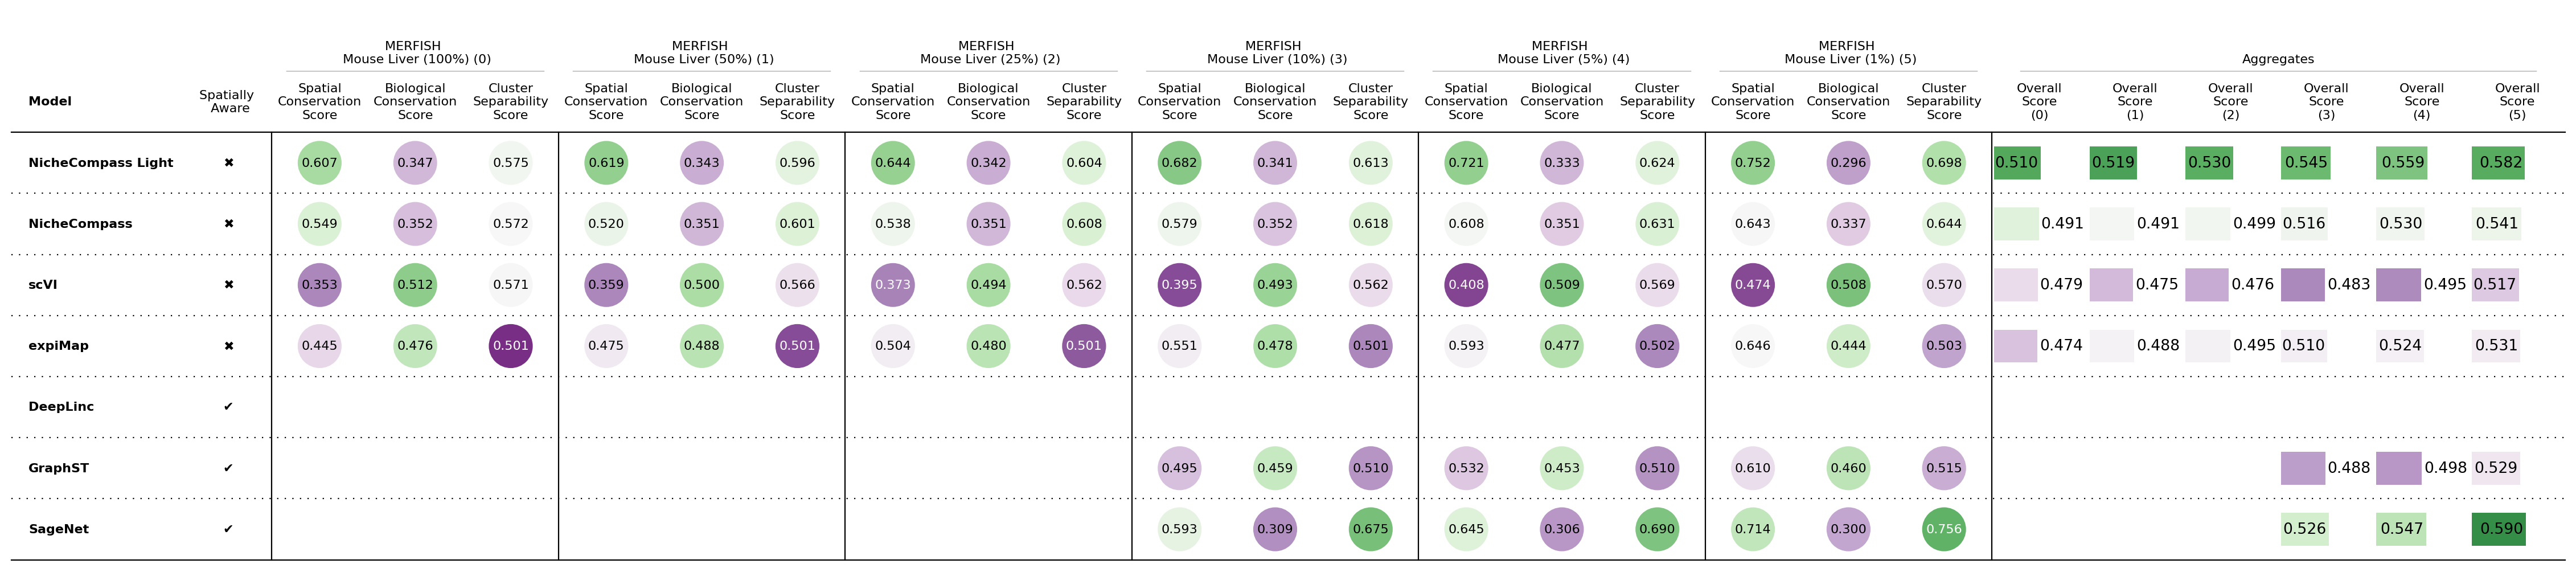

In [24]:
# Plot table
plot_metrics_table(
    df=unrolled_df,
    model_col="model",
    model_col_width=2.,
    group_col="dataset",
    metric_cols=category_cols_single_sample, # metric_cols_single_sample,
    metric_col_weights=category_col_weights_single_sample, # metric_col_weights_single_sample,
    metric_col_titles=[col.replace(" ", "\n") for col in category_col_titles_single_sample],
    metric_col_width=1.1, # 0.8,
    plot_width=36, # 32,
    plot_height=8,
    show=True,
    save_dir=benchmarking_folder_path,
    save_name=f"benchmarking_metrics_vizgen_merfish_mouse_liver.svg")

#### 2.1.5 All Datasets

In [ ]:
datasets = ["slideseqv2_mouse_hippocampus",
            "seqfish_mouse_organogenesis_embryo2",
            "vizgen_merfish_mouse_liver",
            "nanostring_cosmx_human_nsclc_batch5",]
models = ["nichecompass_gatv2conv",
          "nichecompass_gcnconv",
          "deeplinc",
          "graphst",
          "sagenet",
          "scvi",
          "expimap"]

summary_df = pd.DataFrame()
for dataset in datasets:
    for model in models:
        try:
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            benchmark_df[category_cols_single_sample[0]] = np.average(benchmark_df[metric_cols_single_sample[:4]], weights=metric_col_weights_single_sample[:4], axis=1)
            benchmark_df[category_cols_single_sample[1]] = np.average(benchmark_df[metric_cols_single_sample[4:8]], weights=metric_col_weights_single_sample[4:8], axis=1)
            benchmark_df[category_cols_single_sample[2]] = np.average(benchmark_df[metric_cols_single_sample[8:9]], weights=metric_col_weights_single_sample[8:9], axis=1)
            benchmark_df["Overall Score"] = np.average(benchmark_df[category_cols_single_sample[:3]], weights=category_col_weights_single_sample[:3] ,axis=1)
            summary_df = pd.concat([summary_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
                "run_time": [np.nan] * 8
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            summary_df = summary_df.append(missing_run_df, ignore_index=True)
            continue
 
# Reformat for plot
summary_df.replace({"nichecompass_gatv2conv": "NicheCompass",
                    "nichecompass_gcnconv": "NicheCompass Light",
                    "deeplinc": "DeepLinc",
                    "expimap": "expiMap",
                    "graphst": "GraphST",
                    "sagenet": "SageNet",
                    "scvi": "scVI"}, inplace=True)

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    category_cols_single_sample].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=category_cols_single_sample, # metric_cols_single_sample,
   var_name="score_type", 
   value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass GCN", "NicheCompass GATv2", "DeepLinc", "GraphST", "SageNet"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

#print(summary_df["model"].value_counts())
#print(summary_df[summary_df.isna().any(axis=1)])

summary_df["model"] = summary_df["model"].replace("NicheCompass GCN", "NicheCompass Light")
summary_df["model"] = summary_df["model"].replace("NicheCompass GATv2", "NicheCompass")

summary_df["dataset"] = summary_df["dataset"].replace(
    {"slideseqv2_mouse_hippocampus": "SlideSeqV2 Mouse Hippocampus",
     "seqfish_mouse_organogenesis_embryo2": "seqFISH Mouse Organogenesis",
     "nanostring_cosmx_human_nsclc_batch5": "nanoString CosMx Human NSCLC",
     "vizgen_merfish_mouse_liver": "MERFISH Mouse Liver"})

In [ ]:
sns.set_style("whitegrid")

model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "SageNet": "#F46AA2",
                 "scVI": "#FE8B3B",
                 "expiMap": "#7E0028",
                 }

plt.figure(figsize=(7, 4))
ax = sns.barplot(data=summary_df,
                 x="Spatial Conservation Score",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette)
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n') if i < 3 else label.get_text().replace(' H', '\nH', -1).replace(' N', '\nN', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels(new_labels)
plt.ylabel(None)
plt.xlabel("Spatial Conservation Score", fontsize=12)
plt.yticks(fontsize=10)
plt.xticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], fontsize=10)
plt.xlim(0.3, 1.0)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_spatial_conservation_score.svg")
plt.show()

In [ ]:
model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "SageNet": "#F46AA2",
                 "scVI": "#FE8B3B",
                 "expiMap": "#7E0028",
                 }

plt.figure(figsize=(5, 4))
ax = sns.barplot(data=summary_df,
                 x="Biological Conservation Score",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette)
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n', 1) if i < 3 else label.get_text().replace(' H', '\nH', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.set_yticklabels(new_labels)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.ylabel(None)
plt.xlabel("Biological Conservation Score", fontsize=12)
plt.yticks([])
plt.xticks([0.3, 0.4, 0.5, 0.6, 0.7], fontsize=10)
plt.xlim(0.3, 0.7)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_biological_conservation_score.svg")
plt.show()

In [ ]:
model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "SageNet": "#F46AA2",
                 "scVI": "#FE8B3B",
                 "expiMap": "#7E0028",
                 }

plt.figure(figsize=(4.7, 4))
ax = sns.barplot(data=summary_df,
                 x="Cluster Separability Score",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette)
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n', 1) if i < 3 else label.get_text().replace(' H', '\nH', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.set_yticklabels(new_labels)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.ylabel(None)
plt.xlabel("Cluster Separability Score", fontsize=12)
plt.yticks([])
plt.xticks([0.4, 0.5, 0.6, 0.7], fontsize=10)
plt.xlim(0.4, 0.7)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_cluster_separability_score.svg")
plt.show()

In [ ]:
model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "SageNet": "#F46AA2",
                 "scVI": "#FE8B3B",
                 "expiMap": "#7E0028",
                 }

plt.figure(figsize=(4.7, 4))
ax = sns.barplot(data=summary_df,
                 x="Overall Score",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette)
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n', 1) if i < 3 else label.get_text().replace(' H', '\nH', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.set_yticklabels(new_labels)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.ylabel(None)
plt.xlabel("Overall Score", fontsize=12, color="darkred")
plt.yticks([])
plt.xticks([0.4, 0.5, 0.6, 0.7], fontsize=10, color="darkred")
plt.xlim(0.4, 0.7)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_overall_score.svg")
plt.show()

In [ ]:
# Plot table
plot_metrics_table(
    df=unrolled_df,
    model_col="model",
    model_col_width=2.,
    group_col="dataset",
    metric_cols=category_cols_single_sample, # metric_cols_single_sample,
    metric_col_weights=category_col_weights_single_sample, # metric_col_weights_single_sample,
    metric_col_titles=[col.replace(" ", "\n") for col in category_col_titles_single_sample],
    metric_col_width=1.1, # 0.8,
    plot_width=28, # 32,
    plot_height=8,
    show=True,
    save_dir=benchmarking_folder_path,
    save_name=f"benchmarking_metrics_all_datasets.svg")